# Imports

In [1]:
import gdown
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Data Preprocessing

In [2]:
# Define the file ID and destination
file_id = '1_AziIzy6iCUVzQewPlq_QhBvdXlsmyg_'
destination = 'data.zip'

In [3]:
# Download the file from Google Drive
gdown.download(f'https://drive.google.com/uc?id={file_id}', destination, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1_AziIzy6iCUVzQewPlq_QhBvdXlsmyg_
From (redirected): https://drive.google.com/uc?id=1_AziIzy6iCUVzQewPlq_QhBvdXlsmyg_&confirm=t&uuid=617b1c41-5620-401b-8faf-93b3b2674545
To: /content/data.zip
100%|██████████| 572M/572M [00:05<00:00, 98.2MB/s]


'data.zip'

In [4]:
# Unzip the downloaded file
!unzip -q data.zip -d /content/

In [5]:
# Define data augmentation and preprocessing for training and validation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Load and preprocess training and validation data
train_generator = datagen.flow_from_directory(
    '/content/data/train',
    target_size=(256, 256),
    batch_size=64,
    class_mode='categorical',  # Change class_mode to 'categorical'
    shuffle=True
)
validation_generator = datagen.flow_from_directory(
    '/content/data/valid',
    target_size=(256, 256),
    batch_size=64,
    class_mode='categorical',  # Change class_mode to 'categorical'
    shuffle=False
)

Found 4730 images belonging to 7 classes.
Found 1102 images belonging to 7 classes.


# Model Building

In [6]:
# Load pre-trained EfficientNetV2B0
base_model = EfficientNetV2B0(
    weights='imagenet',
    include_top=False,
    input_shape=(256, 256, 3),
    pooling='max',
    classes=7,
    include_preprocessing=True
)

# Add custom classification head
x = base_model.output
predictions = Dense(7, activation='softmax')(x)

# Combine base model and custom head
model = Model(inputs=base_model.input, outputs=predictions)

# Make base model layers trainable
for layer in base_model.layers:
    layer.trainable = True

# Compile the model
model.compile(
    # optimizer=Adam(learning_rate=0.00001),
    optimizer='adamax',
    # optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

24274472/24274472 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 256, 256, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 256, 256, 3)          0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          

# Model Training

In [7]:
history = model.fit(
    train_generator,
    epochs = 5,
    validation_data = validation_generator
)

Epoch 1/5
74/74 [==============================] - 1594s 21s/step - loss: 0.7033 - accuracy: 0.8300 - val_loss: 1.7804 - val_accuracy: 0.5672
Epoch 2/5
74/74 [==============================] - 1510s 20s/step - loss: 0.0962 - accuracy: 0.9702 - val_loss: 1.0528 - val_accuracy: 0.8348
Epoch 3/5
74/74 [==============================] - 1550s 21s/step - loss: 0.0613 - accuracy: 0.9780 - val_loss: 1.2374 - val_accuracy: 0.7623
Epoch 4/5
74/74 [==============================] - 1512s 20s/step - loss: 0.0482 - accuracy: 0.9841 - val_loss: 1.1228 - val_accuracy: 0.8185
Epoch 5/5
74/74 [==============================] - 1537s 21s/step - loss: 0.0346 - accuracy: 0.9888 - val_loss: 1.0789 - val_accuracy: 0.8103


# Model Evaluation

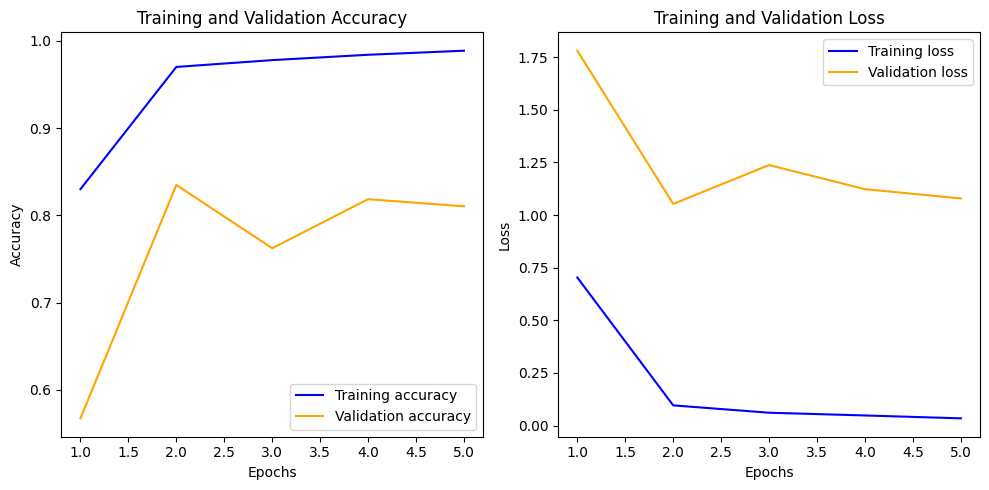

In [8]:
history_dict = history.history

# Extract acc and loss
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

# Get the number of epochs
epochs = range(1, len(acc_values) + 1)

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot the accuracy for training and validation data over epochs
ax[0].plot(epochs, acc_values, label='Training accuracy', color='blue') # Blue Line
ax[0].plot(epochs, val_acc_values, label='Validation accuracy', color='orange') # Orange Line
ax[0].set_title('Training and Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

#Plot the Loss for training and validation data over epochs
ax[1].plot(epochs, loss_values, label='Training loss', color='blue') # Blue Line
ax[1].plot(epochs, val_loss_values, label='Validation loss', color='orange') # Orange Line
ax[1].set_title('Training and Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.tight_layout()
plt.show()

In [9]:
testgen = ImageDataGenerator(
    rescale=1./255
)
test_generator = testgen.flow_from_directory(
    '/content/data/test',
    target_size=(256, 256),
    batch_size=64,
    class_mode='categorical',  # Change class_mode to 'categorical'
    shuffle=False
)

loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

Found 558 images belonging to 7 classes.
9/9 [==============================] - 40s 4s/step - loss: 0.5522 - accuracy: 0.8656
Test Loss: 0.5522
Test Accuracy: 86.56%


# Model Saving

In [11]:
model.save('model_caps_adamax.h5')
# Alternative format
model.save('model_caps_adamax.keras')
model.save('model_caps_adamax.json')